## Importing the dataset

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"leyanajayousi","key":"3f8f6baf8011effea8446d06c24fae88"}'}

In [3]:
!mkdir ~/.kaggle

In [4]:
! mv kaggle.json ~/.kaggle/

In [5]:
! cat ~/.kaggle/kaggle.json

{"username":"leyanajayousi","key":"3f8f6baf8011effea8446d06c24fae88"}

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
License(s): CC0-1.0
100% 612M/612M [00:04<00:00, 142MB/s]
100% 612M/612M [00:04<00:00, 158MB/s]


In [8]:
!unzip -qq gtsrb-german-traffic-sign.zip

## Importing necessary libraries

In [20]:
import paths
from utils import *

from models.DeepLabTL import *
from models.DeepLabResNet50 import *
from models.DeepLabResNet101 import *
from models.DeepLabMobileNet import *
from models.ResNet import *


import matplotlib.pyplot as plt
import pandas as pd
import os
import random
import cv2
import numpy as np

from configparser import ConfigParser
import configparser
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, f1_score, roc_auc_score
from collections import defaultdict
from pathlib import Path
from typing import Any, Callable, Optional
from PIL import Image
import shutil
import copy
import csv
import time
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils import data
import torch.optim as optim
import torchvision.transforms as T
from torchvision import datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.datasets.vision import VisionDataset
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models
import torch.nn.functional as F

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Reading the dataset and extracting first 20 classes from train folder

In [23]:
train_df = pd.read_csv(paths.train_path)
meta_df = pd.read_csv(paths.meta_path)
test_df = pd.read_csv(paths.test_path)

In [24]:
new_train = extract_20_classes(paths.train_folder)

In [25]:
#config MOVEEE
new_train ='/content/Train/new_dataset/Train'

In [26]:
#creating new csv files
meta_csv = filter_and_create_csv(paths.meta_path, 'Meta.csv')
test_csv = filter_and_create_csv(paths.test_path, 'Test.csv')
train_csv = filter_and_create_csv(paths.train_path, 'Train.csv')


In [27]:
#reading csv files using pandas library
read_meta_csv = pd.read_csv(meta_csv)
read_test_csv = pd.read_csv(test_csv)
read_train_csv = pd.read_csv(train_csv)

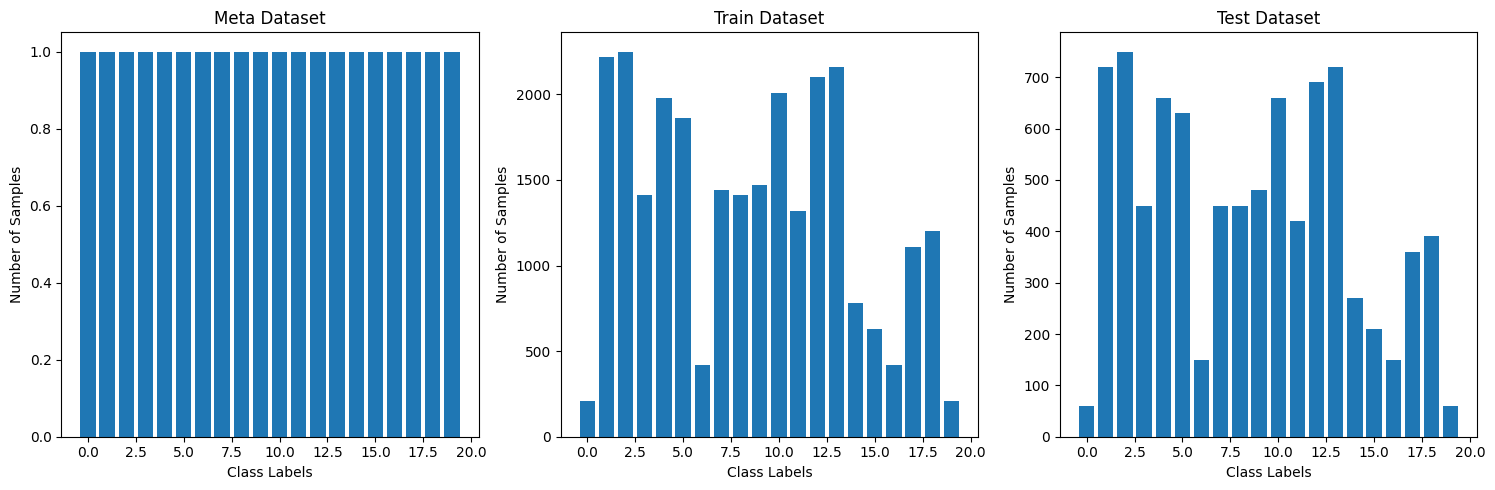

In [ ]:
# Acessing classId column inside csv files
class_counts_Test = read_test_csv['ClassId'].value_counts()
class_counts_Train = read_train_csv['ClassId'].value_counts()
class_counts_Meta = read_meta_csv['ClassId'].value_counts()

class_counts_Meta = class_counts_Meta.sort_index()
class_counts_Train = class_counts_Train.sort_index()
class_counts_Test = class_counts_Test.sort_index()

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plotting for 'Meta' dataset
axs[0].bar(class_counts_Meta.index.astype(int), class_counts_Meta.values, color = 'blue')
axs[0].set_title('Meta Dataset')
axs[0].set_xlabel('Class Labels')
axs[0].set_ylabel('Number of Samples')

# Plotting for 'Train' dataset
axs[1].bar(class_counts_Train.index.astype(int), class_counts_Train.values)
axs[1].set_title('Train Dataset')
axs[1].set_xlabel('Class Labels')
axs[1].set_ylabel('Number of Samples')

# Plotting for 'Test' dataset
axs[2].bar(class_counts_Test.index.astype(int), class_counts_Test.values)
axs[2].set_title('Test Dataset')
axs[2].set_xlabel('Class Labels')
axs[2].set_ylabel('Number of Samples')

axs[0].bar(class_counts_Meta.index.astype(int), class_counts_Meta.values)
axs[0].set_title('Meta Dataset')
axs[0].set_xlabel('Class Labels')
axs[0].set_ylabel('Number of Samples')

custom_ticks = [i for i in range(0, len(class_counts_Meta.index), 1)]
custom_labels = [str(i) for i in custom_ticks]
plt.tight_layout()
plt.show()

## Creating Segmentation masks

In [28]:
csv_file = train_csv# Read the CSV file containing image data
df = pd.read_csv(csv_file)


output_dir = "segmentation_masks"#Create directories for segmentation masks
for i in range(20):
    os.makedirs(os.path.join(output_dir, str(i)), exist_ok=True)


for index, row in df.iterrows():

    image_path = row['Path']
    image = cv2.imread(image_path)


    x1, y1, x2, y2 = row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2']# Extract ROI coordinates and ClassId from the CSV


    class_id = row['ClassId']


    if class_id in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 16, 17]:# Determine the shape type based on the class ID
        shape = 'circle'
    elif class_id in [11, 18, 19]:
        shape = 'triangle'
    elif class_id == 13:
        shape = 'inverse_triangle'
    elif class_id == 14:
        shape = 'octagon'
    elif class_id == 12:
        shape = 'diamond'
    else:
        print(f"Invalid class ID: {class_id}")
        continue


    mask = create_shape_mask(shape, image.shape, x1, y1, x2, y2) # Create the shape mask for the image


    mask_filename = os.path.basename(image_path).replace('.jpg', f'_{shape}_mask.jpg')#Generating the file and saving results
    mask_path = os.path.join(output_dir, str(class_id), mask_filename)
    cv2.imwrite(mask_path, mask)

    #print(f"Mask saved for {image_path} at {mask_path}")

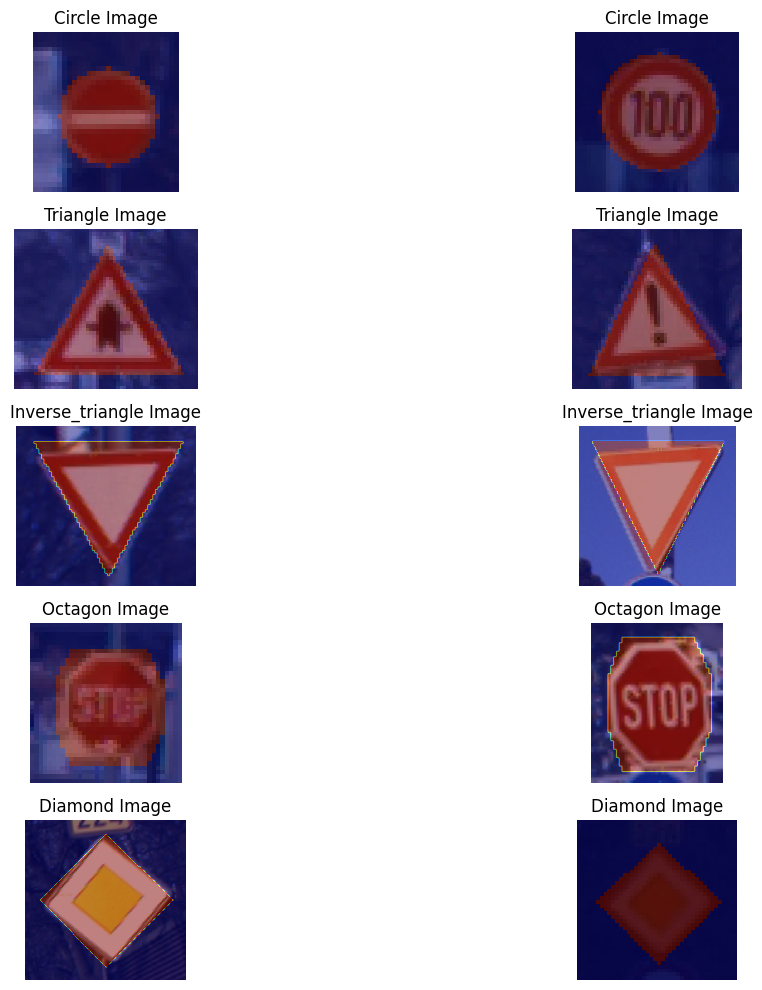

In [ ]:
# Printing random results of resulted segmantation masks
random_images = {}
for shape in ['circle', 'triangle', 'inverse_triangle', 'octagon', 'diamond']:
    random_images[shape] = []

for index, row in df.iterrows():

    x1, y1, x2, y2 = row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2']


    class_id = row['ClassId']


    if class_id in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 16, 17]:
        shape = 'circle'
    elif class_id in [11, 18, 19]:
        shape = 'triangle'
    elif class_id == 13:
        shape = 'inverse_triangle'
    elif class_id == 14:
        shape = 'octagon'
    elif class_id == 12:
        shape = 'diamond'
    else:
        print(f"Invalid class ID: {class_id}")
        continue


    random_images[shape].append((row['Path'], x1, y1, x2, y2))


plt.figure(figsize=(15, 10))
for i, (shape, images) in enumerate(random_images.items()):
    for j in range(2):
        if len(images) == 0:
            continue
        image_path, x1, y1, x2, y2 = random.choice(images)
        image = cv2.imread(image_path)
        mask = create_shape_mask(shape, image.shape, x1, y1, x2, y2)


        plt.subplot(5, 2, i*2 + j + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.imshow(mask, cmap='jet', alpha=0.5)
        plt.title(f"{shape.capitalize()} Image")
        plt.axis('off')

plt.tight_layout()
plt.show()

In [29]:
# Source paths
source_train_path = '/content/Train/new_dataset/Train'
source_mask_path = '/content/segmentation_masks'

# Destination path
destination_path = '/content/data_dir2'

create_and_copy_folders(source_train_path, source_mask_path, destination_path)

## Config file

In [30]:
# Initialize the config parser
config = configparser.ConfigParser()

# Read the config.ini file
config.read('config.ini')
epochs = config.getint('Common', 'epochs')

batch_size1 = config.getint('Training1', 'batch_size') #32

batch_size2 = config.getint('Training2', 'batch_size')# 64

In [31]:
# Retrieve common values from the config file
base_directory = config['Common']['base_directory']
# Retrieve subdirectory paths
data_subdirectory = config['Paths']['data_subdirectory']
data_directory = os.path.join(base_directory, data_subdirectory)

## Deeplabv3 and ResNet50 Results

In [32]:
exp_directory = '/content/experiment_results'
main_resnet50(data_directory, exp_directory, epochs, batch_size1)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 119MB/s]


Epoch 1/15
----------


  0%|          | 0/666 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 666/666 [01:28<00:00,  7.49it/s]


Train Loss: 0.0651


100%|██████████| 167/167 [00:17<00:00,  9.46it/s]


Test Loss: 1.3478
{'epoch': 1, 'Train_loss': 0.06506843119859695, 'Test_loss': 1.3478258848190308, 'Train_f1_score': 0.7705024402742352, 'Train_auroc': 0.906762794401281, 'Test_f1_score': 0.7573126180862536, 'Test_auroc': 0.8689086659012815}
Epoch 2/15
----------


100%|██████████| 666/666 [01:29<00:00,  7.42it/s]


Train Loss: 0.0719


100%|██████████| 167/167 [00:17<00:00,  9.67it/s]


Test Loss: 0.8917
{'epoch': 2, 'Train_loss': 0.07191953808069229, 'Test_loss': 0.8916960954666138, 'Train_f1_score': 0.8021617966915937, 'Train_auroc': 0.9347125465150675, 'Test_f1_score': 0.7971092809854163, 'Test_auroc': 0.9180334399843166}
Epoch 3/15
----------


 97%|█████████▋| 643/666 [01:24<00:03,  7.63it/s]


KeyboardInterrupt: 

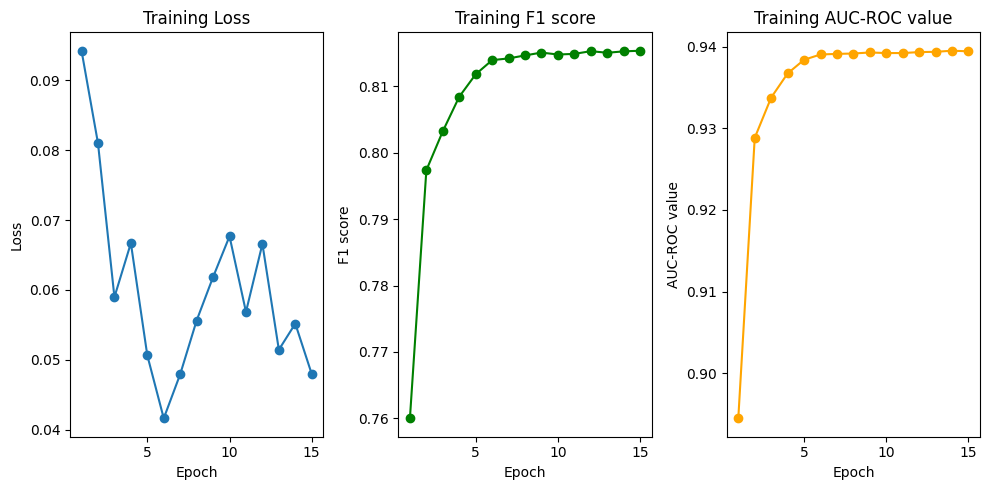

In [ ]:
#Plotting graphs of results obtained
with open('/content/experiment_results/log.csv', 'r') as file:
    reader = csv.DictReader(file)
    epochs = []
    losses = []
    fone = []
    aurocs = []
    for row in reader:
        epochs.append(int(row['epoch']))
        losses.append(float(row['Train_loss']))
        fone.append(float(row['Train_f1_score']))
        aurocs.append(float(row['Train_auroc']))

# Create plots
plt.figure(figsize=(10, 5))

# Plot loss
plt.subplot(1, 3, 1)
plt.plot(epochs, losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

# Plot accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, fone, marker='o', color='green')
plt.xlabel('Epoch')
plt.ylabel('F1 score')
plt.title('Training F1 score')

# Plot accuracy
plt.subplot(1, 3, 3)
plt.plot(epochs, aurocs, marker='o', color='orange')
plt.xlabel('Epoch')
plt.ylabel('AUC-ROC value')
plt.title('Training AUC-ROC value')


plt.tight_layout()
plt.show()


In [ ]:
main_second_resnet50(data_directory, exp_directory, epochs, batch_size2)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15
----------


100%|█████████▉| 332/333 [01:11<00:00,  5.05it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 333/333 [01:11<00:00,  4.63it/s]


Train Loss: 0.0544


100%|██████████| 84/84 [00:16<00:00,  5.02it/s]


Test Loss: 0.0595
{'epoch': 1, 'Train_loss': 0.05435589700937271, 'Test_loss': 0.05948532372713089, 'Train_f1_score': 0.7878659433437862, 'Train_auroc': 0.9246311823100706, 'Test_f1_score': 0.8279382970961997, 'Test_auroc': 0.9274074129981935}
Epoch 2/15
----------


100%|██████████| 333/333 [01:11<00:00,  4.65it/s]


Train Loss: 0.0548


100%|██████████| 84/84 [00:16<00:00,  5.06it/s]


Test Loss: 0.0526
{'epoch': 2, 'Train_loss': 0.05483315512537956, 'Test_loss': 0.052608296275138855, 'Train_f1_score': 0.8096877141719335, 'Train_auroc': 0.9368118759646988, 'Test_f1_score': 0.8211263847284295, 'Test_auroc': 0.9297889033275925}
Epoch 3/15
----------


100%|██████████| 333/333 [01:13<00:00,  4.54it/s]


Train Loss: 0.0560


100%|██████████| 84/84 [00:17<00:00,  4.84it/s]


Test Loss: 0.0580
{'epoch': 3, 'Train_loss': 0.05597288906574249, 'Test_loss': 0.057950716465711594, 'Train_f1_score': 0.8127037846602709, 'Train_auroc': 0.9381594504074836, 'Test_f1_score': 0.8115631481611495, 'Test_auroc': 0.9282707908328226}
Epoch 4/15
----------


100%|██████████| 333/333 [01:12<00:00,  4.56it/s]


Train Loss: 0.0562


100%|██████████| 84/84 [00:15<00:00,  5.40it/s]


Test Loss: 0.0575
{'epoch': 4, 'Train_loss': 0.056172411888837814, 'Test_loss': 0.057517360895872116, 'Train_f1_score': 0.8148751375327545, 'Train_auroc': 0.9389246175659166, 'Test_f1_score': 0.8041879871778878, 'Test_auroc': 0.928172855655744}
Epoch 5/15
----------


  4%|▍         | 13/333 [00:03<01:21,  3.92it/s]


KeyboardInterrupt: 

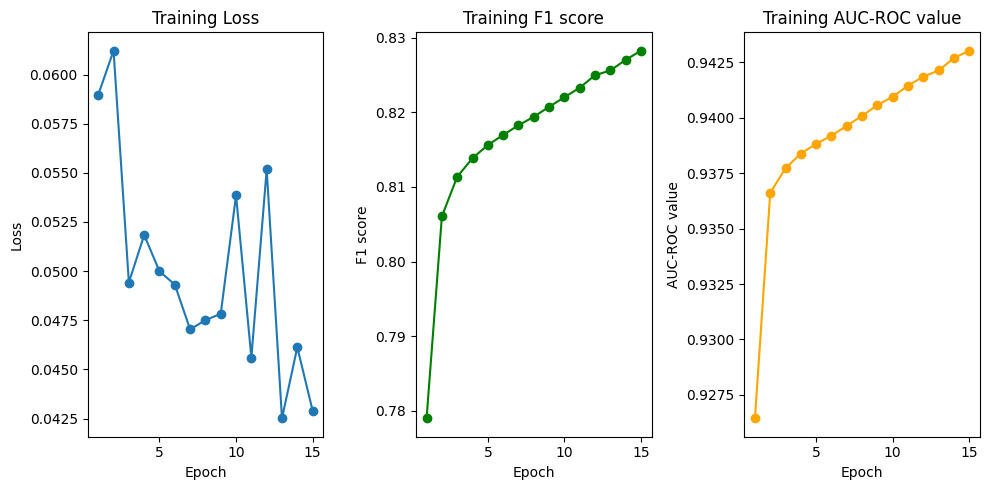

In [ ]:
#Printing results obtained
with open('/content/experiment_results2/log.csv', 'r') as file:
    reader = csv.DictReader(file)
    epochs = []
    losses = []
    fone = []
    aurocs = []
    for row in reader:
        epochs.append(int(row['epoch']))
        losses.append(float(row['Train_loss']))
        fone.append(float(row['Train_f1_score']))
        aurocs.append(float(row['Train_auroc']))

# Create plots
plt.figure(figsize=(10, 5))

# Plot loss
plt.subplot(1, 3, 1)
plt.plot(epochs, losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

# Plot accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, fone, marker='o', color='green')
plt.xlabel('Epoch')
plt.ylabel('F1 score')
plt.title('Training F1 score')

# Plot accuracy
plt.subplot(1, 3, 3)
plt.plot(epochs, aurocs, marker='o', color='orange')
plt.xlabel('Epoch')
plt.ylabel('AUC-ROC value')
plt.title('Training AUC-ROC value')


plt.tight_layout()
plt.show()


In [ ]:
data_directory =  '/content/data_dir2'
exp_directory = '/content/experiment_results_resnet50dice'
main_third_resnet50(data_directory, exp_directory, epochs, batch_size2)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 164MB/s]


Epoch 1/15
----------


  0%|          | 0/666 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  6%|▋         | 43/666 [00:08<02:01,  5.14it/s]


KeyboardInterrupt: 

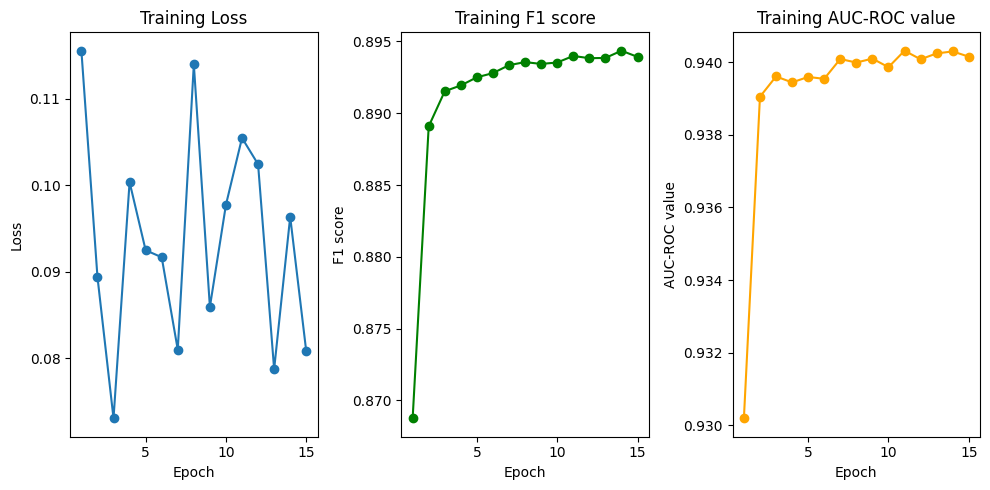

In [ ]:
#Printing results obtained
with open('/content/experiment_results_resnet50dice/log.csv', 'r') as file:
    reader = csv.DictReader(file)
    epochs = []
    losses = []
    fone = []
    aurocs = []
    for row in reader:
        epochs.append(int(row['epoch']))
        losses.append(float(row['Train_loss']))
        fone.append(float(row['Train_f1_score']))
        aurocs.append(float(row['Train_auroc']))

# Create plots
plt.figure(figsize=(10, 5))

# Plot loss
plt.subplot(1, 3, 1)
plt.plot(epochs, losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

# Plot accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, fone, marker='o', color='green')
plt.xlabel('Epoch')
plt.ylabel('F1 score')
plt.title('Training F1 score')

# Plot accuracy
plt.subplot(1, 3, 3)
plt.plot(epochs, aurocs, marker='o', color='orange')
plt.xlabel('Epoch')
plt.ylabel('AUC-ROC value')
plt.title('Training AUC-ROC value')


plt.tight_layout()
plt.show()


## Deeplabv3 and ResNet101 results

In [ ]:
data_directory =  '/content/data_dir2'
exp_directory = '/content/experiment_results_resnet101'
main_resnet101(data_directory, exp_directory, epochs, batch_size2)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:02<00:00, 91.1MB/s]


Epoch 1/15
----------


  5%|▍         | 16/333 [00:05<01:51,  2.85it/s]


KeyboardInterrupt: 

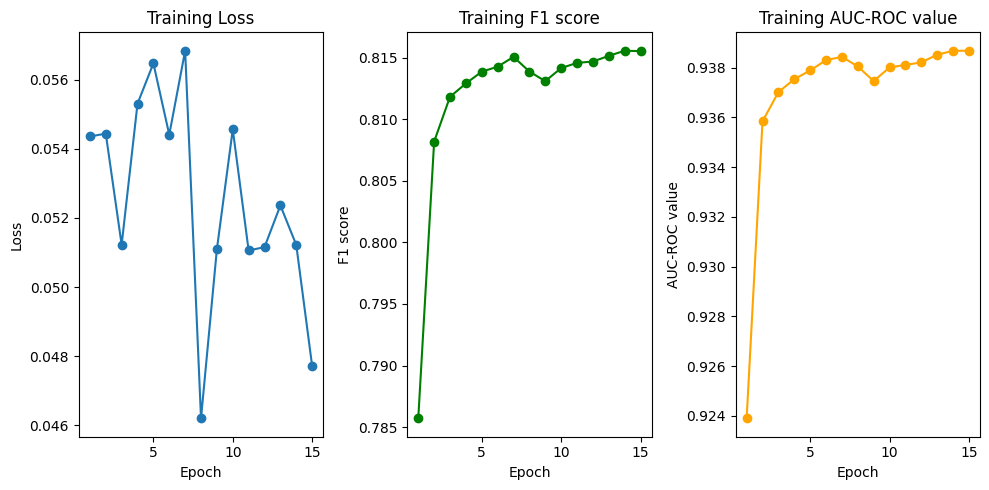

In [ ]:
#Plotting graphs for results
with open('/content/experiment_results_resnet101/log.csv', 'r') as file:
    reader = csv.DictReader(file)
    epochs = []
    losses = []
    fone = []
    aurocs = []
    for row in reader:
        epochs.append(int(row['epoch']))
        losses.append(float(row['Train_loss']))
        fone.append(float(row['Train_f1_score']))
        aurocs.append(float(row['Train_auroc']))

# Create plots
plt.figure(figsize=(10, 5))

# Plot loss
plt.subplot(1, 3, 1)
plt.plot(epochs, losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

# Plot accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, fone, marker='o', color='green')
plt.xlabel('Epoch')
plt.ylabel('F1 score')
plt.title('Training F1 score')

# Plot accuracy
plt.subplot(1, 3, 3)
plt.plot(epochs, aurocs, marker='o', color='orange')
plt.xlabel('Epoch')
plt.ylabel('AUC-ROC value')
plt.title('Training AUC-ROC value')


plt.tight_layout()
plt.show()


In [ ]:
data_directory =  '/content/data_dir2'
exp_directory = '/content/experiment_results_secondtry_resnet101'
main_second_resnet101(data_directory, exp_directory, epochs, batch_size1)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:01<00:00, 156MB/s]


Epoch 1/15
----------


100%|██████████| 666/666 [02:03<00:00,  5.41it/s]


Train Loss: 0.1208


100%|██████████| 167/167 [00:19<00:00,  8.72it/s]


Test Loss: 8402.5234
{'epoch': 1, 'Train_loss': 0.12075082212686539, 'Test_loss': 8402.5234375, 'Train_f1_score': 0.7781396587745069, 'Train_auroc': 0.9195571408754608, 'Test_f1_score': 0.7464319318964805, 'Test_auroc': 0.7843270336640844}
Epoch 2/15
----------


100%|██████████| 666/666 [02:03<00:00,  5.38it/s]


Train Loss: 0.1239


100%|██████████| 167/167 [00:20<00:00,  8.29it/s]


Test Loss: 0.0791
{'epoch': 2, 'Train_loss': 0.1238769143819809, 'Test_loss': 0.07910327613353729, 'Train_f1_score': 0.79569254860939, 'Train_auroc': 0.9233803145112576, 'Test_f1_score': 0.7929791033660478, 'Test_auroc': 0.9048193338376758}
Epoch 3/15
----------


100%|██████████| 666/666 [02:03<00:00,  5.39it/s]


Train Loss: 0.0894


100%|██████████| 167/167 [00:19<00:00,  8.52it/s]


Test Loss: 0.1014
{'epoch': 3, 'Train_loss': 0.08940257877111435, 'Test_loss': 0.10140169411897659, 'Train_f1_score': 0.7971113266807475, 'Train_auroc': 0.9242778142672741, 'Test_f1_score': 0.7839061705891704, 'Test_auroc': 0.9042196360394008}
Epoch 4/15
----------


100%|██████████| 666/666 [02:03<00:00,  5.41it/s]


Train Loss: 0.0905


100%|██████████| 167/167 [00:19<00:00,  8.60it/s]


Test Loss: 0.0641
{'epoch': 4, 'Train_loss': 0.0905395895242691, 'Test_loss': 0.06408146768808365, 'Train_f1_score': 0.7976311052507994, 'Train_auroc': 0.9252483037466597, 'Test_f1_score': 0.8083585013893041, 'Test_auroc': 0.9225524114651444}
Epoch 5/15
----------


100%|██████████| 666/666 [02:03<00:00,  5.38it/s]


Train Loss: 0.0746


100%|██████████| 167/167 [00:19<00:00,  8.54it/s]


Test Loss: 0.1097
{'epoch': 5, 'Train_loss': 0.07459579408168793, 'Test_loss': 0.10968375951051712, 'Train_f1_score': 0.7969382894542526, 'Train_auroc': 0.9249020675178395, 'Test_f1_score': 0.7845470665914439, 'Test_auroc': 0.8966586182267642}
Epoch 6/15
----------


100%|██████████| 666/666 [02:03<00:00,  5.41it/s]


Train Loss: 0.0463


100%|██████████| 167/167 [00:18<00:00,  8.84it/s]


Test Loss: 0.0785
{'epoch': 6, 'Train_loss': 0.04631754383444786, 'Test_loss': 0.07848500460386276, 'Train_f1_score': 0.7967395140526141, 'Train_auroc': 0.9246563279330907, 'Test_f1_score': 0.7923601122981568, 'Test_auroc': 0.9218441165465876}
Epoch 7/15
----------


100%|██████████| 666/666 [02:02<00:00,  5.42it/s]


Train Loss: 0.0604


100%|██████████| 167/167 [00:19<00:00,  8.59it/s]


Test Loss: 0.0563
{'epoch': 7, 'Train_loss': 0.06038741394877434, 'Test_loss': 0.05631512776017189, 'Train_f1_score': 0.797264675983386, 'Train_auroc': 0.9249747100393673, 'Test_f1_score': 0.7812280882691857, 'Test_auroc': 0.9021488069210862}
Epoch 8/15
----------


100%|██████████| 666/666 [02:03<00:00,  5.37it/s]


Train Loss: 0.0596


100%|██████████| 167/167 [00:19<00:00,  8.67it/s]


Test Loss: 0.0791
{'epoch': 8, 'Train_loss': 0.05956902354955673, 'Test_loss': 0.0790710523724556, 'Train_f1_score': 0.7972685193726099, 'Train_auroc': 0.9248920652411499, 'Test_f1_score': 0.7703181700010032, 'Test_auroc': 0.8558823340157338}
Epoch 9/15
----------


100%|██████████| 666/666 [02:02<00:00,  5.42it/s]


Train Loss: 0.0547


100%|██████████| 167/167 [00:19<00:00,  8.71it/s]


Test Loss: 0.0593
{'epoch': 9, 'Train_loss': 0.05472232773900032, 'Test_loss': 0.05934329330921173, 'Train_f1_score': 0.7973551432855491, 'Train_auroc': 0.9250333051233264, 'Test_f1_score': 0.7882254410043326, 'Test_auroc': 0.9099405943096606}
Epoch 10/15
----------


100%|██████████| 666/666 [02:03<00:00,  5.41it/s]


Train Loss: 0.0645


100%|██████████| 167/167 [00:20<00:00,  8.28it/s]


Test Loss: 0.0558
{'epoch': 10, 'Train_loss': 0.06446067243814468, 'Test_loss': 0.05584915354847908, 'Train_f1_score': 0.8014199614270302, 'Train_auroc': 0.9307768098960648, 'Test_f1_score': 0.794857209272837, 'Test_auroc': 0.9117291787376809}
Epoch 11/15
----------


100%|██████████| 666/666 [02:03<00:00,  5.40it/s]


Train Loss: 0.0630


100%|██████████| 167/167 [00:19<00:00,  8.60it/s]


Test Loss: 0.0529
{'epoch': 11, 'Train_loss': 0.06295351684093475, 'Test_loss': 0.052940789610147476, 'Train_f1_score': 0.8093180933701585, 'Train_auroc': 0.9368437912574352, 'Test_f1_score': 0.7883509562987204, 'Test_auroc': 0.8960118646334143}
Epoch 12/15
----------


100%|██████████| 666/666 [02:03<00:00,  5.41it/s]


Train Loss: 0.0469


100%|██████████| 167/167 [00:19<00:00,  8.56it/s]


Test Loss: 0.0597
{'epoch': 12, 'Train_loss': 0.046946704387664795, 'Test_loss': 0.05969208478927612, 'Train_f1_score': 0.8116302702621333, 'Train_auroc': 0.9381395347674201, 'Test_f1_score': 0.7913444114327701, 'Test_auroc': 0.9346253061780859}
Epoch 13/15
----------


100%|██████████| 666/666 [02:03<00:00,  5.40it/s]


Train Loss: 0.0547


100%|██████████| 167/167 [00:19<00:00,  8.38it/s]


Test Loss: 0.0455
{'epoch': 13, 'Train_loss': 0.05472686514258385, 'Test_loss': 0.04552032798528671, 'Train_f1_score': 0.8129612696987912, 'Train_auroc': 0.9387494964061942, 'Test_f1_score': 0.8222793149664511, 'Test_auroc': 0.9355723341317725}
Epoch 14/15
----------


100%|██████████| 666/666 [02:03<00:00,  5.40it/s]


Train Loss: 0.0475


100%|██████████| 167/167 [00:20<00:00,  8.32it/s]


Test Loss: 0.0469
{'epoch': 14, 'Train_loss': 0.047477543354034424, 'Test_loss': 0.046946581453084946, 'Train_f1_score': 0.8142179597679421, 'Train_auroc': 0.9389516678663653, 'Test_f1_score': 0.8079223457957807, 'Test_auroc': 0.9349478021258247}
Epoch 15/15
----------


100%|██████████| 666/666 [02:02<00:00,  5.42it/s]


Train Loss: 0.0595


100%|██████████| 167/167 [00:19<00:00,  8.61it/s]


Test Loss: 0.0512
{'epoch': 15, 'Train_loss': 0.059542376548051834, 'Test_loss': 0.05121235549449921, 'Train_f1_score': 0.8146318252190761, 'Train_auroc': 0.9391008581119838, 'Test_f1_score': 0.8143800820173006, 'Test_auroc': 0.9353546926225432}
Training complete in 35m 44s
Lowest Loss: 0.045520


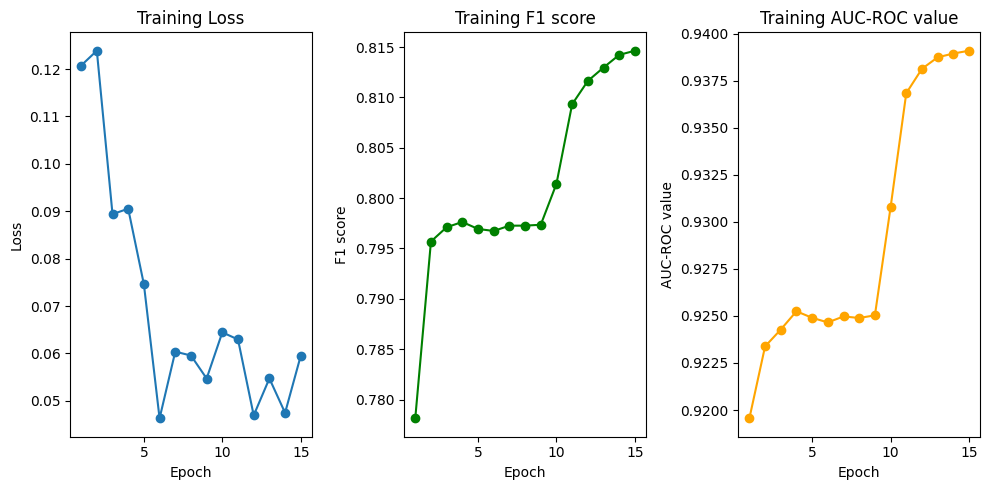

In [ ]:
#Printing results obtained
with open('/content/experiment_results_secondtry_resnet101/log.csv', 'r') as file:
    reader = csv.DictReader(file)
    epochs = []
    losses = []
    fone = []
    aurocs = []
    for row in reader:
        epochs.append(int(row['epoch']))
        losses.append(float(row['Train_loss']))
        fone.append(float(row['Train_f1_score']))
        aurocs.append(float(row['Train_auroc']))

# Create plots
plt.figure(figsize=(10, 5))

# Plot loss
plt.subplot(1, 3, 1)
plt.plot(epochs, losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

# Plot accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, fone, marker='o', color='green')
plt.xlabel('Epoch')
plt.ylabel('F1 score')
plt.title('Training F1 score')

# Plot accuracy
plt.subplot(1, 3, 3)
plt.plot(epochs, aurocs, marker='o', color='orange')
plt.xlabel('Epoch')
plt.ylabel('AUC-ROC value')
plt.title('Training AUC-ROC value')


plt.tight_layout()
plt.show()


In [ ]:
data_directory =  '/content/data_dir2'
exp_directory = '/content/experiment_results_resnet101_dice'
main_third_resnet101(data_directory, exp_directory, epochs, batch_size1)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:01<00:00, 165MB/s]


Epoch 1/15
----------


100%|██████████| 666/666 [02:25<00:00,  4.59it/s]


Train Loss: 0.1162


100%|██████████| 167/167 [00:18<00:00,  8.98it/s]


Test Loss: 0.0839
{'epoch': 1, 'Train_loss': 0.1162484884262085, 'Test_loss': 0.0838584303855896, 'Train_f1_score': 0.8701730553101976, 'Train_auroc': 0.9308979507527105, 'Test_f1_score': 0.8764831516376778, 'Test_auroc': 0.932703629882019}
Epoch 2/15
----------


100%|██████████| 666/666 [02:06<00:00,  5.29it/s]


Train Loss: 0.0867


100%|██████████| 167/167 [00:18<00:00,  9.00it/s]


Test Loss: 0.1144
{'epoch': 2, 'Train_loss': 0.08673751354217529, 'Test_loss': 0.11435806751251221, 'Train_f1_score': 0.8867007347523983, 'Train_auroc': 0.9387343335935103, 'Test_f1_score': 0.8854961469196855, 'Test_auroc': 0.9352071550749548}
Epoch 3/15
----------


100%|██████████| 666/666 [02:05<00:00,  5.29it/s]


Train Loss: 0.0808


100%|██████████| 167/167 [00:18<00:00,  8.93it/s]


Test Loss: 0.0913
{'epoch': 3, 'Train_loss': 0.08081138134002686, 'Test_loss': 0.09133154153823853, 'Train_f1_score': 0.890322889138009, 'Train_auroc': 0.9397048203198952, 'Test_f1_score': 0.886189205167489, 'Test_auroc': 0.9357371904204499}
Epoch 4/15
----------


100%|██████████| 666/666 [02:05<00:00,  5.31it/s]


Train Loss: 0.0796


100%|██████████| 167/167 [00:18<00:00,  9.14it/s]


Test Loss: 0.1009
{'epoch': 4, 'Train_loss': 0.07961082458496094, 'Test_loss': 0.10090982913970947, 'Train_f1_score': 0.891714929337283, 'Train_auroc': 0.9400446950580954, 'Test_f1_score': 0.8857704947999216, 'Test_auroc': 0.9352707550398416}
Epoch 5/15
----------


100%|██████████| 666/666 [02:05<00:00,  5.29it/s]


Train Loss: 0.0725


100%|██████████| 167/167 [00:19<00:00,  8.68it/s]


Test Loss: 0.0948
{'epoch': 5, 'Train_loss': 0.07250016927719116, 'Test_loss': 0.0947691798210144, 'Train_f1_score': 0.892606020695166, 'Train_auroc': 0.9402506921481074, 'Test_f1_score': 0.8838937948922799, 'Test_auroc': 0.9335501425544224}
Epoch 6/15
----------


100%|██████████| 666/666 [02:06<00:00,  5.28it/s]


Train Loss: 0.0984


100%|██████████| 167/167 [00:18<00:00,  8.92it/s]


Test Loss: 0.0830
{'epoch': 6, 'Train_loss': 0.09835636615753174, 'Test_loss': 0.08296900987625122, 'Train_f1_score': 0.892727585443035, 'Train_auroc': 0.9400499007990446, 'Test_f1_score': 0.8846716992227098, 'Test_auroc': 0.9348635824312156}
Epoch 7/15
----------


100%|██████████| 666/666 [02:05<00:00,  5.30it/s]


Train Loss: 0.0946


100%|██████████| 167/167 [00:19<00:00,  8.65it/s]


Test Loss: 0.1091
{'epoch': 7, 'Train_loss': 0.09456324577331543, 'Test_loss': 0.1090502142906189, 'Train_f1_score': 0.8933311203054514, 'Train_auroc': 0.9401268426593969, 'Test_f1_score': 0.8829956817181859, 'Test_auroc': 0.9345623591050463}
Epoch 8/15
----------


100%|██████████| 666/666 [02:05<00:00,  5.31it/s]


Train Loss: 0.1040


100%|██████████| 167/167 [00:18<00:00,  9.00it/s]


Test Loss: 0.0917
{'epoch': 8, 'Train_loss': 0.10401785373687744, 'Test_loss': 0.091677725315094, 'Train_f1_score': 0.8931058893447336, 'Train_auroc': 0.9399405848415088, 'Test_f1_score': 0.8842806365244973, 'Test_auroc': 0.9356537696782473}
Epoch 9/15
----------


100%|██████████| 666/666 [02:05<00:00,  5.29it/s]


Train Loss: 0.0834


100%|██████████| 167/167 [00:18<00:00,  8.92it/s]


Test Loss: 0.0976
{'epoch': 9, 'Train_loss': 0.08337730169296265, 'Test_loss': 0.09761494398117065, 'Train_f1_score': 0.8940472113297779, 'Train_auroc': 0.9402615120258102, 'Test_f1_score': 0.8912872482726739, 'Test_auroc': 0.9356170277683828}
Epoch 10/15
----------


100%|██████████| 666/666 [02:05<00:00,  5.32it/s]


Train Loss: 0.1142


100%|██████████| 167/167 [00:18<00:00,  9.02it/s]


Test Loss: 0.1444
{'epoch': 10, 'Train_loss': 0.11416840553283691, 'Test_loss': 0.14435607194900513, 'Train_f1_score': 0.8933747265047353, 'Train_auroc': 0.9400059258835395, 'Test_f1_score': 0.8862640866362477, 'Test_auroc': 0.935294790946257}
Epoch 11/15
----------


100%|██████████| 666/666 [02:05<00:00,  5.29it/s]


Train Loss: 0.1118


100%|██████████| 167/167 [00:18<00:00,  8.87it/s]


Test Loss: 0.1459
{'epoch': 11, 'Train_loss': 0.11179518699645996, 'Test_loss': 0.14588803052902222, 'Train_f1_score': 0.8942483932697012, 'Train_auroc': 0.9401868969104321, 'Test_f1_score': 0.8884654911227782, 'Test_auroc': 0.9352665080669108}
Epoch 12/15
----------


100%|██████████| 666/666 [02:05<00:00,  5.32it/s]


Train Loss: 0.0903


100%|██████████| 167/167 [00:18<00:00,  9.15it/s]


Test Loss: 0.0816
{'epoch': 12, 'Train_loss': 0.09034252166748047, 'Test_loss': 0.08164077997207642, 'Train_f1_score': 0.8940248023119192, 'Train_auroc': 0.9399083789652802, 'Test_f1_score': 0.8904713094626131, 'Test_auroc': 0.9353879669724025}
Epoch 13/15
----------


100%|██████████| 666/666 [02:05<00:00,  5.29it/s]


Train Loss: 0.0839


100%|██████████| 167/167 [00:19<00:00,  8.74it/s]


Test Loss: 0.1155
{'epoch': 13, 'Train_loss': 0.08392477035522461, 'Test_loss': 0.1154664158821106, 'Train_f1_score': 0.8942762436051642, 'Train_auroc': 0.940143148935853, 'Test_f1_score': 0.8886564571815347, 'Test_auroc': 0.9351558024453317}
Epoch 14/15
----------


100%|██████████| 666/666 [02:05<00:00,  5.32it/s]


Train Loss: 0.1116


100%|██████████| 167/167 [00:18<00:00,  9.04it/s]


Test Loss: 0.1197
{'epoch': 14, 'Train_loss': 0.1115911602973938, 'Test_loss': 0.1196967363357544, 'Train_f1_score': 0.8944493897201545, 'Train_auroc': 0.9402409723419527, 'Test_f1_score': 0.8893222710631902, 'Test_auroc': 0.9357443556139236}
Epoch 15/15
----------


100%|██████████| 666/666 [02:05<00:00,  5.32it/s]


Train Loss: 0.1272


100%|██████████| 167/167 [00:19<00:00,  8.62it/s]


Test Loss: 0.0975
{'epoch': 15, 'Train_loss': 0.12721186876296997, 'Test_loss': 0.09747505187988281, 'Train_f1_score': 0.8943896833742015, 'Train_auroc': 0.9401226640675581, 'Test_f1_score': 0.8853704469530586, 'Test_auroc': 0.9358888954606179}
Training complete in 36m 26s
Lowest Loss: 0.081641


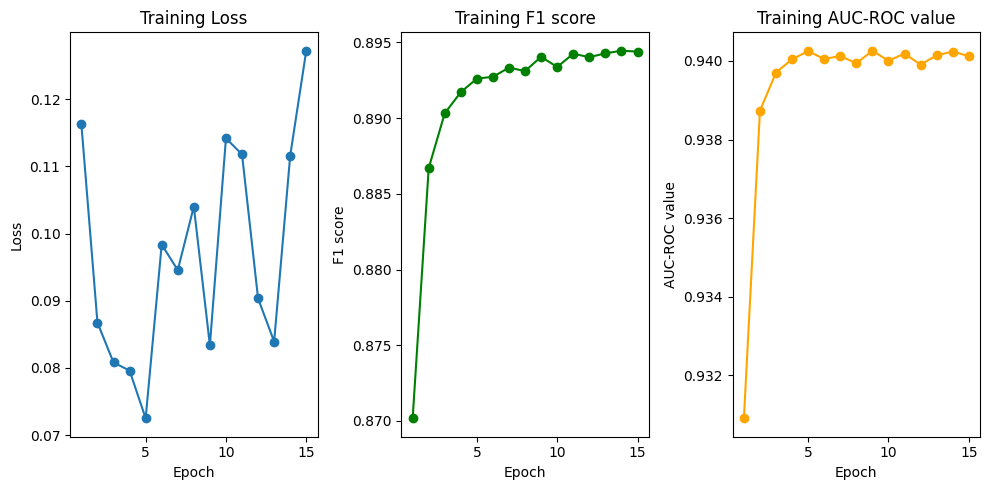

In [ ]:
#Printing results obtained
with open('/content/experiment_results_resnet101_dice/log.csv', 'r') as file:
    reader = csv.DictReader(file)
    epochs = []
    losses = []
    fone = []
    aurocs = []
    for row in reader:
        epochs.append(int(row['epoch']))
        losses.append(float(row['Train_loss']))
        fone.append(float(row['Train_f1_score']))
        aurocs.append(float(row['Train_auroc']))

# Create plots
plt.figure(figsize=(10, 5))

# Plot loss
plt.subplot(1, 3, 1)
plt.plot(epochs, losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

# Plot accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, fone, marker='o', color='green')
plt.xlabel('Epoch')
plt.ylabel('F1 score')
plt.title('Training F1 score')

# Plot accuracy
plt.subplot(1, 3, 3)
plt.plot(epochs, aurocs, marker='o', color='orange')
plt.xlabel('Epoch')
plt.ylabel('AUC-ROC value')
plt.title('Training AUC-ROC value')


plt.tight_layout()
plt.show()


## Deeplabv3 and MobileNet results

In [ ]:
data_directory =  '/content/data_dir2'
exp_directory = '/content/experiment_results_mobilenet_v3'
main_mobilenet(data_directory, exp_directory, epochs, batch_size2)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth
100%|██████████| 42.3M/42.3M [00:01<00:00, 28.1MB/s]


Epoch 1/15
----------


  6%|▌         | 20/333 [00:04<01:03,  4.94it/s]


KeyboardInterrupt: 

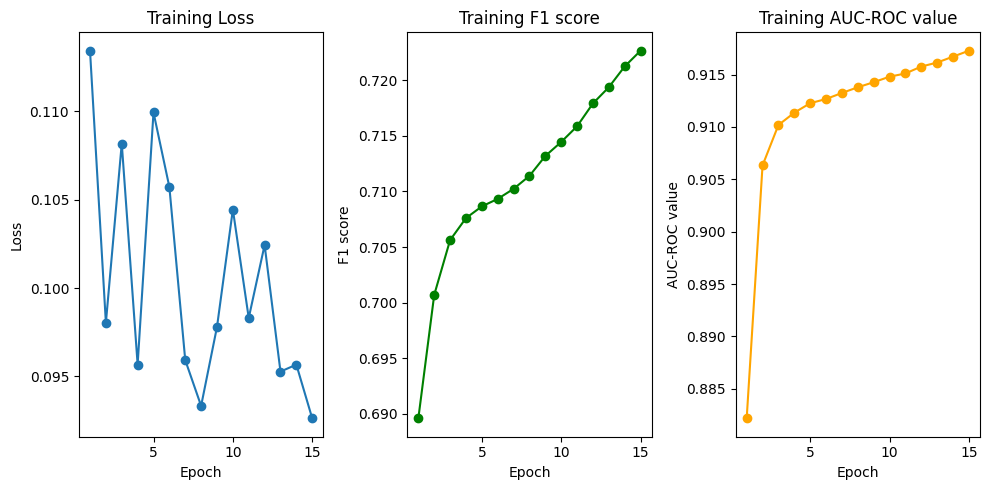

In [ ]:
#Plotting graphs for obtained results
with open('/content/experiment_results_mobilenet_v3/log.csv', 'r') as file:
    reader = csv.DictReader(file)
    epochs = []
    losses = []
    fone = []
    aurocs = []
    for row in reader:
        epochs.append(int(row['epoch']))
        losses.append(float(row['Train_loss']))
        fone.append(float(row['Train_f1_score']))
        aurocs.append(float(row['Train_auroc']))

# Create plots
plt.figure(figsize=(10, 5))

# Plot loss
plt.subplot(1, 3, 1)
plt.plot(epochs, losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

# Plot accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, fone, marker='o', color='green')
plt.xlabel('Epoch')
plt.ylabel('F1 score')
plt.title('Training F1 score')

# Plot accuracy
plt.subplot(1, 3, 3)
plt.plot(epochs, aurocs, marker='o', color='orange')
plt.xlabel('Epoch')
plt.ylabel('AUC-ROC value')
plt.title('Training AUC-ROC value')


plt.tight_layout()
plt.show()


In [ ]:
data_directory =  '/content/data_dir2'
exp_directory = '/content/experiment_results_mobilenet_v3_secontry'
main_second_mobilenet(data_directory, exp_directory, epochs, batch_size1)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15
----------


  0%|          | 0/666 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|█████████▉| 664/666 [01:10<00:00, 10.79it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 666/666 [01:10<00:00,  9.47it/s]


Train Loss: 0.1216


100%|██████████| 167/167 [00:14<00:00, 11.27it/s]


Test Loss: 0.1152
{'epoch': 1, 'Train_loss': 0.1216229796409607, 'Test_loss': 0.11524154990911484, 'Train_f1_score': 0.6941203171328155, 'Train_auroc': 0.8969608929177968, 'Test_f1_score': 0.7047702906032006, 'Test_auroc': 0.9084067937007082}
Epoch 2/15
----------


100%|██████████| 666/666 [01:10<00:00,  9.47it/s]


Train Loss: 0.1238


100%|██████████| 167/167 [00:14<00:00, 11.35it/s]


Test Loss: 0.0901
{'epoch': 2, 'Train_loss': 0.12383712828159332, 'Test_loss': 0.09006830304861069, 'Train_f1_score': 0.7071272052552139, 'Train_auroc': 0.9130060516441754, 'Test_f1_score': 0.6965398840127603, 'Test_auroc': 0.9078768706474106}
Epoch 3/15
----------


100%|██████████| 666/666 [01:10<00:00,  9.45it/s]


Train Loss: 0.1169


100%|██████████| 167/167 [00:14<00:00, 11.25it/s]


Test Loss: 0.1059
{'epoch': 3, 'Train_loss': 0.1169184073805809, 'Test_loss': 0.10594874620437622, 'Train_f1_score': 0.7078891639716547, 'Train_auroc': 0.9140037100298776, 'Test_f1_score': 0.709220943119403, 'Test_auroc': 0.9096485364638347}
Epoch 4/15
----------


100%|██████████| 666/666 [01:10<00:00,  9.45it/s]


Train Loss: 0.1126


100%|██████████| 167/167 [00:14<00:00, 11.50it/s]


Test Loss: 0.0909
{'epoch': 4, 'Train_loss': 0.11261413246393204, 'Test_loss': 0.09094902127981186, 'Train_f1_score': 0.707588720541422, 'Train_auroc': 0.9145148412698002, 'Test_f1_score': 0.7154113680162495, 'Test_auroc': 0.9100849091189209}
Epoch 5/15
----------


100%|██████████| 666/666 [01:09<00:00,  9.55it/s]


Train Loss: 0.0953


100%|██████████| 167/167 [00:14<00:00, 11.49it/s]


Test Loss: 0.1104
{'epoch': 5, 'Train_loss': 0.0953083410859108, 'Test_loss': 0.11038719117641449, 'Train_f1_score': 0.7080574223157736, 'Train_auroc': 0.914929645285266, 'Test_f1_score': 0.7005056872329737, 'Test_auroc': 0.9110563129961721}
Epoch 6/15
----------


100%|██████████| 666/666 [01:10<00:00,  9.42it/s]


Train Loss: 0.0874


100%|██████████| 167/167 [00:14<00:00, 11.92it/s]


Test Loss: 0.1062
{'epoch': 6, 'Train_loss': 0.08738735318183899, 'Test_loss': 0.10619202256202698, 'Train_f1_score': 0.7076715707837016, 'Train_auroc': 0.9149532858922445, 'Test_f1_score': 0.7086220843365012, 'Test_auroc': 0.9071996277152872}
Epoch 7/15
----------


100%|██████████| 666/666 [01:10<00:00,  9.45it/s]


Train Loss: 0.1174


100%|██████████| 167/167 [00:13<00:00, 12.47it/s]


Test Loss: 0.0981
{'epoch': 7, 'Train_loss': 0.11737456917762756, 'Test_loss': 0.09805446118116379, 'Train_f1_score': 0.7082171903837505, 'Train_auroc': 0.9149302700743851, 'Test_f1_score': 0.7018487594715537, 'Test_auroc': 0.9096068769700875}
Epoch 8/15
----------


100%|██████████| 666/666 [01:10<00:00,  9.40it/s]


Train Loss: 0.0852


100%|██████████| 167/167 [00:13<00:00, 12.65it/s]


Test Loss: 0.1035
{'epoch': 8, 'Train_loss': 0.08520395308732986, 'Test_loss': 0.10353311896324158, 'Train_f1_score': 0.7079681930861734, 'Train_auroc': 0.915242076255598, 'Test_f1_score': 0.7176923750590349, 'Test_auroc': 0.9104280296070519}
Epoch 9/15
----------


100%|██████████| 666/666 [01:10<00:00,  9.38it/s]


Train Loss: 0.0988


100%|██████████| 167/167 [00:13<00:00, 12.24it/s]


Test Loss: 0.1153
{'epoch': 9, 'Train_loss': 0.09882932156324387, 'Test_loss': 0.1152520477771759, 'Train_f1_score': 0.7085336398382911, 'Train_auroc': 0.9153611726374007, 'Test_f1_score': 0.7117790626056963, 'Test_auroc': 0.9094268254573971}
Epoch 10/15
----------


100%|██████████| 666/666 [01:11<00:00,  9.27it/s]


Train Loss: 0.0941


100%|██████████| 167/167 [00:13<00:00, 12.33it/s]


Test Loss: 0.0810
{'epoch': 10, 'Train_loss': 0.09406641125679016, 'Test_loss': 0.08103249967098236, 'Train_f1_score': 0.7085413268843086, 'Train_auroc': 0.9153341278856916, 'Test_f1_score': 0.7084962607923786, 'Test_auroc': 0.9092467405253845}
Epoch 11/15
----------


100%|██████████| 666/666 [01:12<00:00,  9.21it/s]


Train Loss: 0.1231


100%|██████████| 167/167 [00:13<00:00, 12.33it/s]


Test Loss: 0.0999
{'epoch': 11, 'Train_loss': 0.12308450788259506, 'Test_loss': 0.09994767606258392, 'Train_f1_score': 0.7085910175573517, 'Train_auroc': 0.9151724382210452, 'Test_f1_score': 0.7055531290155688, 'Test_auroc': 0.9096869531683968}
Epoch 12/15
----------


100%|██████████| 666/666 [01:11<00:00,  9.25it/s]


Train Loss: 0.1116


100%|██████████| 167/167 [00:13<00:00, 12.14it/s]


Test Loss: 0.0988
{'epoch': 12, 'Train_loss': 0.11161354184150696, 'Test_loss': 0.0987662747502327, 'Train_f1_score': 0.7086323125958304, 'Train_auroc': 0.9153427978884798, 'Test_f1_score': 0.6967018414426082, 'Test_auroc': 0.9088237464124663}
Epoch 13/15
----------


100%|██████████| 666/666 [01:11<00:00,  9.33it/s]


Train Loss: 0.0979


100%|██████████| 167/167 [00:14<00:00, 11.74it/s]


Test Loss: 0.0948
{'epoch': 13, 'Train_loss': 0.0978810116648674, 'Test_loss': 0.09480244666337967, 'Train_f1_score': 0.7085510970270341, 'Train_auroc': 0.915238071812881, 'Test_f1_score': 0.7095445372927424, 'Test_auroc': 0.9097360741276537}
Epoch 14/15
----------


100%|██████████| 666/666 [01:11<00:00,  9.35it/s]


Train Loss: 0.0877


100%|██████████| 167/167 [00:14<00:00, 11.44it/s]


Test Loss: 0.1064
{'epoch': 14, 'Train_loss': 0.08773517608642578, 'Test_loss': 0.1063823476433754, 'Train_f1_score': 0.7084951981034943, 'Train_auroc': 0.9154187666181554, 'Test_f1_score': 0.700521095098013, 'Test_auroc': 0.9085829015041001}
Epoch 15/15
----------


100%|██████████| 666/666 [01:11<00:00,  9.37it/s]


Train Loss: 0.0975


100%|██████████| 167/167 [00:14<00:00, 11.19it/s]


Test Loss: 0.0808
{'epoch': 15, 'Train_loss': 0.09745195508003235, 'Test_loss': 0.08081840723752975, 'Train_f1_score': 0.7088783182210701, 'Train_auroc': 0.9153330883913939, 'Test_f1_score': 0.7117180237940554, 'Test_auroc': 0.9095186782206865}
Training complete in 21m 17s
Lowest Loss: 0.080818


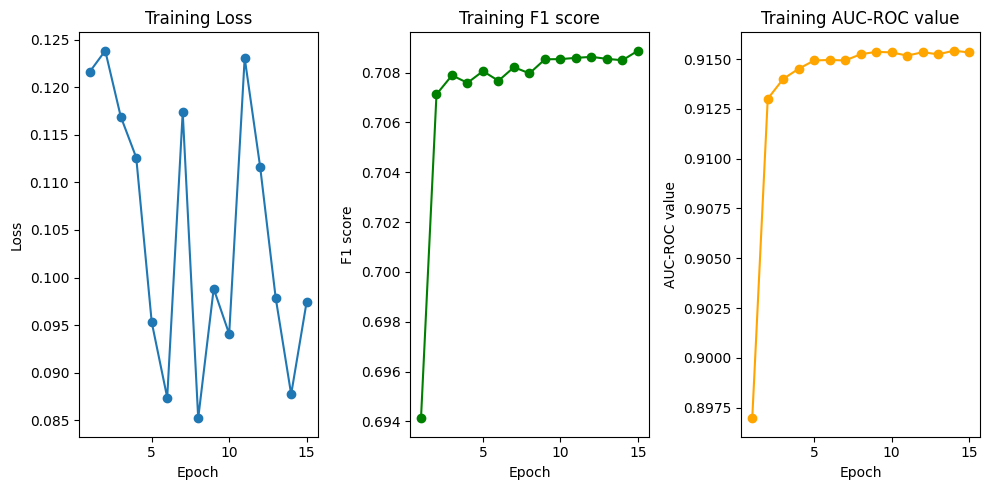

In [ ]:
#Plotting graphs for obtained results
with open('/content/experiment_results_mobilenet_v3_secontry/log.csv', 'r') as file:
    reader = csv.DictReader(file)
    epochs = []
    losses = []
    fone = []
    aurocs = []
    for row in reader:
        epochs.append(int(row['epoch']))
        losses.append(float(row['Train_loss']))
        fone.append(float(row['Train_f1_score']))
        aurocs.append(float(row['Train_auroc']))

# Create plots
plt.figure(figsize=(10, 5))

# Plot loss
plt.subplot(1, 3, 1)
plt.plot(epochs, losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

# Plot accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, fone, marker='o', color='green')
plt.xlabel('Epoch')
plt.ylabel('F1 score')
plt.title('Training F1 score')

# Plot accuracy
plt.subplot(1, 3, 3)
plt.plot(epochs, aurocs, marker='o', color='orange')
plt.xlabel('Epoch')
plt.ylabel('AUC-ROC value')
plt.title('Training AUC-ROC value')


plt.tight_layout()
plt.show()


In [ ]:
data_directory =  '/content/data_dir2'
exp_directory = '/content/experiment_results_mobilenet_v3_dice'
main_third_mobilenet(data_directory, exp_directory, epochs, batch_size1)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth
100%|██████████| 42.3M/42.3M [00:00<00:00, 162MB/s]

Epoch 1/15
----------


  0%|          | 0/666 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|█████████▉| 665/666 [01:20<00:00, 10.36it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 666/666 [01:20<00:00,  8.31it/s]


Train Loss: 0.1958


 99%|█████████▉| 165/167 [00:15<00:00, 12.58it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 167/167 [00:15<00:00, 10.52it/s]


Test Loss: 0.1276
{'epoch': 1, 'Train_loss': 0.19578230381011963, 'Test_loss': 0.12762796878814697, 'Train_f1_score': 0.8529713633810108, 'Train_auroc': 0.9226624038287793, 'Test_f1_score': 0.8543471614581161, 'Test_auroc': 0.916750945276915}
Epoch 2/15
----------


100%|██████████| 666/666 [01:14<00:00,  8.93it/s]


Train Loss: 0.1257


100%|██████████| 167/167 [00:15<00:00, 10.83it/s]


Test Loss: 0.1667
{'epoch': 2, 'Train_loss': 0.12566977739334106, 'Test_loss': 0.16667580604553223, 'Train_f1_score': 0.8616513348081124, 'Train_auroc': 0.9254056601796571, 'Test_f1_score': 0.842873596646948, 'Test_auroc': 0.9158289109119205}
Epoch 3/15
----------


100%|██████████| 666/666 [01:13<00:00,  9.06it/s]


Train Loss: 0.0870


100%|██████████| 167/167 [00:15<00:00, 10.86it/s]


Test Loss: 0.1236
{'epoch': 3, 'Train_loss': 0.08700698614120483, 'Test_loss': 0.12356042861938477, 'Train_f1_score': 0.8626492528222426, 'Train_auroc': 0.9256537604427137, 'Test_f1_score': 0.8613853601375508, 'Test_auroc': 0.9209162899778831}
Epoch 4/15
----------


100%|██████████| 666/666 [01:13<00:00,  9.06it/s]


Train Loss: 0.1541


100%|██████████| 167/167 [00:15<00:00, 10.88it/s]


Test Loss: 0.1131
{'epoch': 4, 'Train_loss': 0.15405607223510742, 'Test_loss': 0.11306226253509521, 'Train_f1_score': 0.8631246468341925, 'Train_auroc': 0.9256246056301002, 'Test_f1_score': 0.8592339405617212, 'Test_auroc': 0.9198729374030454}
Epoch 5/15
----------


100%|██████████| 666/666 [01:14<00:00,  8.95it/s]


Train Loss: 0.1085


100%|██████████| 167/167 [00:14<00:00, 11.47it/s]


Test Loss: 0.1347
{'epoch': 5, 'Train_loss': 0.1085018515586853, 'Test_loss': 0.13470035791397095, 'Train_f1_score': 0.8625114019727776, 'Train_auroc': 0.9255312384994401, 'Test_f1_score': 0.8592713033546284, 'Test_auroc': 0.9209982542253492}
Epoch 6/15
----------


100%|██████████| 666/666 [01:15<00:00,  8.78it/s]


Train Loss: 0.1521


100%|██████████| 167/167 [00:13<00:00, 12.17it/s]


Test Loss: 0.1353
{'epoch': 6, 'Train_loss': 0.15213638544082642, 'Test_loss': 0.13533055782318115, 'Train_f1_score': 0.8627893002987466, 'Train_auroc': 0.9257490353273737, 'Test_f1_score': 0.854452988973193, 'Test_auroc': 0.9171892693789357}
Epoch 7/15
----------


100%|██████████| 666/666 [01:13<00:00,  9.06it/s]


Train Loss: 0.1004


100%|██████████| 167/167 [00:14<00:00, 11.60it/s]


Test Loss: 0.1002
{'epoch': 7, 'Train_loss': 0.10040313005447388, 'Test_loss': 0.10017776489257812, 'Train_f1_score': 0.8633500014501584, 'Train_auroc': 0.9265083771615393, 'Test_f1_score': 0.8587901239909851, 'Test_auroc': 0.921060685251471}
Epoch 8/15
----------


100%|██████████| 666/666 [01:13<00:00,  9.03it/s]


Train Loss: 0.1028


100%|██████████| 167/167 [00:15<00:00, 10.72it/s]


Test Loss: 0.1319
{'epoch': 8, 'Train_loss': 0.10277873277664185, 'Test_loss': 0.13187557458877563, 'Train_f1_score': 0.8635972455295892, 'Train_auroc': 0.9259839603423236, 'Test_f1_score': 0.8580926510658881, 'Test_auroc': 0.9210763522022185}
Epoch 9/15
----------


100%|██████████| 666/666 [01:12<00:00,  9.19it/s]


Train Loss: 0.1023


100%|██████████| 167/167 [00:15<00:00, 10.78it/s]


Test Loss: 0.1211
{'epoch': 9, 'Train_loss': 0.1022915244102478, 'Test_loss': 0.12111836671829224, 'Train_f1_score': 0.8641608795692611, 'Train_auroc': 0.9263256379174706, 'Test_f1_score': 0.8604720620093919, 'Test_auroc': 0.9204609675258671}
Epoch 10/15
----------


100%|██████████| 666/666 [01:13<00:00,  9.03it/s]


Train Loss: 0.1368


100%|██████████| 167/167 [00:15<00:00, 11.06it/s]


Test Loss: 0.1290
{'epoch': 10, 'Train_loss': 0.1367710828781128, 'Test_loss': 0.1290387511253357, 'Train_f1_score': 0.8635957588684446, 'Train_auroc': 0.9262777805034346, 'Test_f1_score': 0.8572778675041365, 'Test_auroc': 0.919625889201442}
Epoch 11/15
----------


100%|██████████| 666/666 [01:12<00:00,  9.20it/s]


Train Loss: 0.1274


100%|██████████| 167/167 [00:15<00:00, 10.81it/s]


Test Loss: 0.1161
{'epoch': 11, 'Train_loss': 0.12735486030578613, 'Test_loss': 0.11612898111343384, 'Train_f1_score': 0.8640490884058953, 'Train_auroc': 0.9262425992424653, 'Test_f1_score': 0.8596898556155785, 'Test_auroc': 0.920515122822193}
Epoch 12/15
----------


100%|██████████| 666/666 [01:12<00:00,  9.23it/s]


Train Loss: 0.1443


100%|██████████| 167/167 [00:15<00:00, 10.73it/s]


Test Loss: 0.1195
{'epoch': 12, 'Train_loss': 0.14431250095367432, 'Test_loss': 0.11954551935195923, 'Train_f1_score': 0.8634759138083821, 'Train_auroc': 0.9257615547004066, 'Test_f1_score': 0.8597274181760957, 'Test_auroc': 0.9211632481773706}
Epoch 13/15
----------


100%|██████████| 666/666 [01:14<00:00,  8.99it/s]


Train Loss: 0.1108


100%|██████████| 167/167 [00:15<00:00, 10.83it/s]


Test Loss: 0.1248
{'epoch': 13, 'Train_loss': 0.11075598001480103, 'Test_loss': 0.12479472160339355, 'Train_f1_score': 0.8644998284459586, 'Train_auroc': 0.9265747596925685, 'Test_f1_score': 0.8611071894005254, 'Test_auroc': 0.920680000458143}
Epoch 14/15
----------


100%|██████████| 666/666 [01:15<00:00,  8.85it/s]


Train Loss: 0.1359


100%|██████████| 167/167 [00:14<00:00, 11.69it/s]


Test Loss: 0.0925
{'epoch': 14, 'Train_loss': 0.1359269618988037, 'Test_loss': 0.09249472618103027, 'Train_f1_score': 0.8644336862801165, 'Train_auroc': 0.9265350281626341, 'Test_f1_score': 0.8613608558546404, 'Test_auroc': 0.9204430298280389}
Epoch 15/15
----------


100%|██████████| 666/666 [01:15<00:00,  8.82it/s]


Train Loss: 0.1343


100%|██████████| 167/167 [00:15<00:00, 10.61it/s]


Test Loss: 0.1299
{'epoch': 15, 'Train_loss': 0.13426268100738525, 'Test_loss': 0.12987011671066284, 'Train_f1_score': 0.8644856135436844, 'Train_auroc': 0.9259078882913169, 'Test_f1_score': 0.8618334378029631, 'Test_auroc': 0.919375670735797}
Training complete in 22m 23s
Lowest Loss: 0.092495


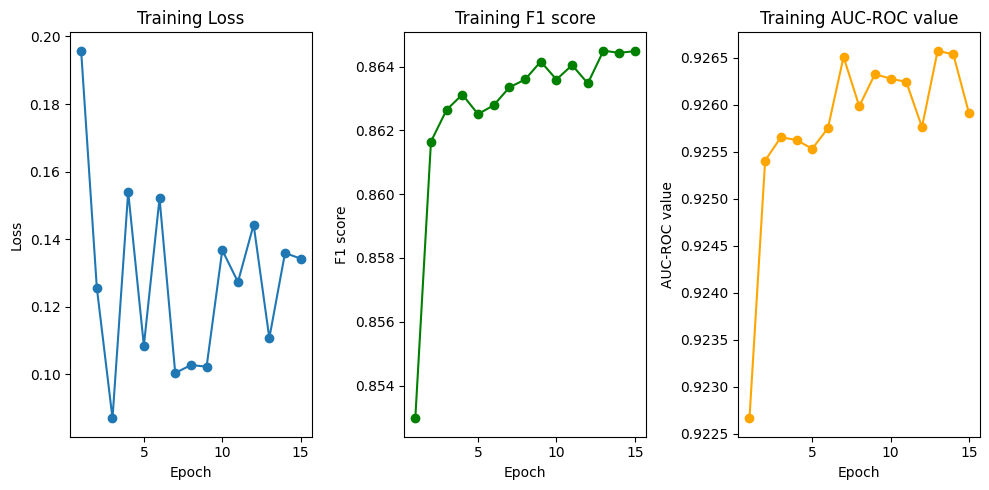

In [ ]:
#Plotting graphs for obtained results
with open('/content/experiment_results_mobilenet_v3_dice/log.csv', 'r') as file:
    reader = csv.DictReader(file)
    epochs = []
    losses = []
    fone = []
    aurocs = []
    for row in reader:
        epochs.append(int(row['epoch']))
        losses.append(float(row['Train_loss']))
        fone.append(float(row['Train_f1_score']))
        aurocs.append(float(row['Train_auroc']))

# Create plots
plt.figure(figsize=(10, 5))

# Plot loss
plt.subplot(1, 3, 1)
plt.plot(epochs, losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

# Plot accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, fone, marker='o', color='green')
plt.xlabel('Epoch')
plt.ylabel('F1 score')
plt.title('Training F1 score')

# Plot accuracy
plt.subplot(1, 3, 3)
plt.plot(epochs, aurocs, marker='o', color='orange')
plt.xlabel('Epoch')
plt.ylabel('AUC-ROC value')
plt.title('Training AUC-ROC value')


plt.tight_layout()
plt.show()


## Preprocessing the dataset and balancing the classes using oversampling

In [ ]:
#reading config_ini file
#classes = config['dataset']['num_classes']
meanstr = config['transformsVal']['mean']
stdstr = config['transformsVal']['std']
meant = [float(val) for val in meanstr.split(',')]
stdt = [float(val) for val in stdstr.split(',')]

In [ ]:
#setting transforms values for preprocessing
transforms = T.Compose([
  T.RandomResizedCrop(size=225),
  T.RandomRotation(degrees=15),
  T.RandomHorizontalFlip(),
  T.ToTensor(),
  T.Normalize(meant, stdt)
])


In [ ]:
#splitting train folder for train and validation with 0.8 and 0.2 ratio
mydataset = ImageFolder(root = new_train, transform=transforms)
dataset_size = mydataset.__len__()
train_count = int(dataset_size * 0.8)
val_count = dataset_size - train_count
train_dataset, valid_dataset = random_split(mydataset, [train_count, val_count])

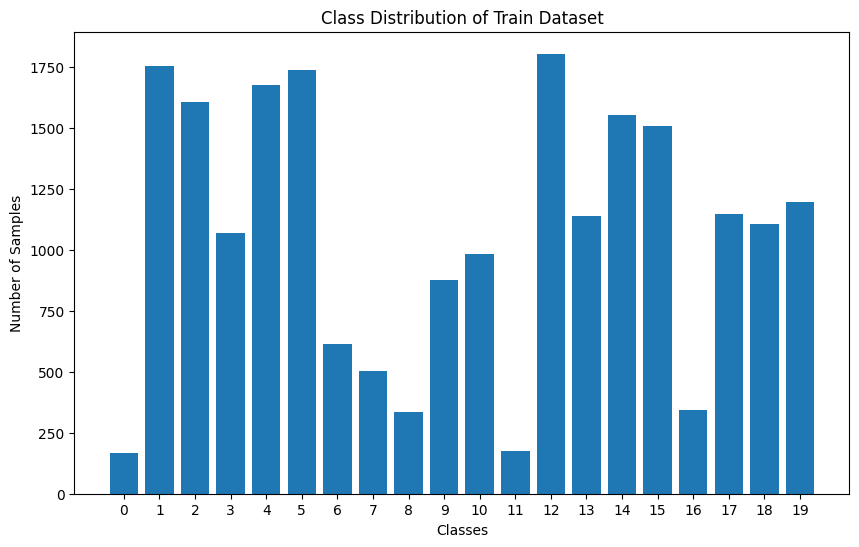

In [ ]:
# Plotting class distribution of train_dataset before balancing
class_counts = {}
for _, label in train_dataset:
    class_counts[label] = class_counts.get(label, 0) + 1

labels, counts = zip(*sorted(class_counts.items()))

plt.figure(figsize=(10, 6))
plt.bar(labels, counts)
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Class Distribution of Train Dataset')
plt.xticks(labels)
plt.show()

In [ ]:
# balancing classes in train set using oversampling
y_train_indices = train_dataset.indices

y_train = [mydataset.targets[i] for i in y_train_indices]

class_sample_count = np.array(
    [len(np.where(y_train == t)[0]) for t in np.unique(y_train)])

In [ ]:
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in y_train])
samples_weight = torch.from_numpy(samples_weight)

In [ ]:
sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))
train_dataloader = DataLoader(train_dataset, batch_size=5, sampler=sampler)
valid_loader = DataLoader(valid_dataset, batch_size = 5)

In [ ]:
# Count the number of images in each class in the training dataset
counts_after_split = {}
for _, label in train_dataset:
    label_str = str(label)
    if label_str not in counts_after_split:
        counts_after_split[label_str] = 1
    else:
        counts_after_split[label_str] += 1

print(counts_after_split)

{'1': 1752, '4': 1674, '12': 1804, '3': 1070, '15': 1507, '5': 1736, '19': 1197, '10': 982, '16': 344, '13': 1140, '17': 1147, '6': 613, '14': 1551, '7': 502, '18': 1106, '8': 337, '9': 878, '2': 1608, '11': 175, '0': 165}


Class 7: 1090 images
Class 10: 1059 images
Class 4: 1058 images
Class 1: 1099 images
Class 13: 1097 images
Class 2: 1121 images
Class 17: 1039 images
Class 16: 1070 images
Class 3: 1074 images
Class 15: 1050 images
Class 0: 1063 images
Class 14: 1044 images
Class 8: 995 images
Class 19: 1074 images
Class 12: 1070 images
Class 5: 1117 images
Class 18: 1056 images
Class 9: 1024 images
Class 11: 1060 images
Class 6: 1028 images


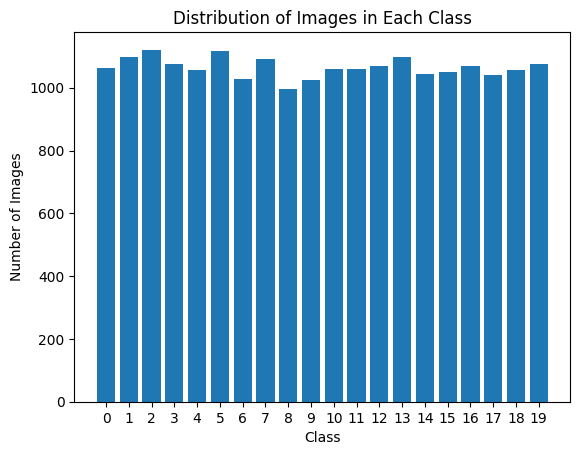

In [ ]:
#printing the graph of data distribution after balancing
class_counts = defaultdict(int)

for images, labels in train_dataloader:
    for label in labels.flatten().tolist():
        class_counts[label] += 1

for label, count in class_counts.items():
     print(f"Class {label}: {count} images")


# Create a bar plot
labels, counts = zip(*sorted(class_counts.items(), key=lambda x: int(x[0])))

plt.bar(labels, counts)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images in Each Class')
plt.xticks(labels)
plt.show()

In [ ]:
#checking number of images in each loader
dataloaders = {'training':train_dataloader,'validation':valid_loader}
dataset_sizes = {'training':len(train_dataloader.dataset),'validation':len(valid_loader.dataset)}
print(dataset_sizes)

{'training': 21288, 'validation': 5322}


## Training Adam optimizer model

In [ ]:
#classes = config.getint['dataset']['num_classes']
%%time
model = ResNet50(img_channel=3, num_classes = 20).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001, weight_decay=0.0001)
num_epochs = 20
batch_size = 64
out_path = get_unique_filename(prefix='mymodel', suffix='.pt', folder='/content')

#train the model
history = capture_output(Train, model, criterion, optimizer, num_epochs, batch_size, dataloaders, out_path)
print(history)

In [ ]:
# Extracting loss values from the captured output
train_losses = []
valid_losses = []

for line in history:
    if line.startswith('Training Epoch'):
        train_loss = float(line.split('Loss: ')[1].split()[0])
        train_losses.append(train_loss)
    elif line.startswith('Validation Epoch'):
        valid_loss = float(line.split('Loss: ')[1].split()[0])
        valid_losses.append(valid_loss)

## Plotting graphs regarding the results of training of Adam optimizer model

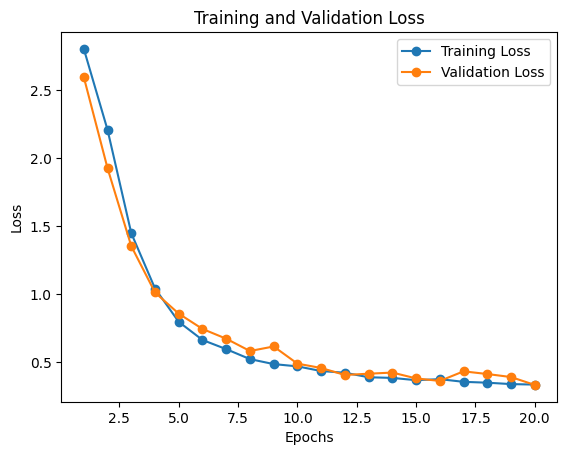

In [ ]:
# plotting loss graphs
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


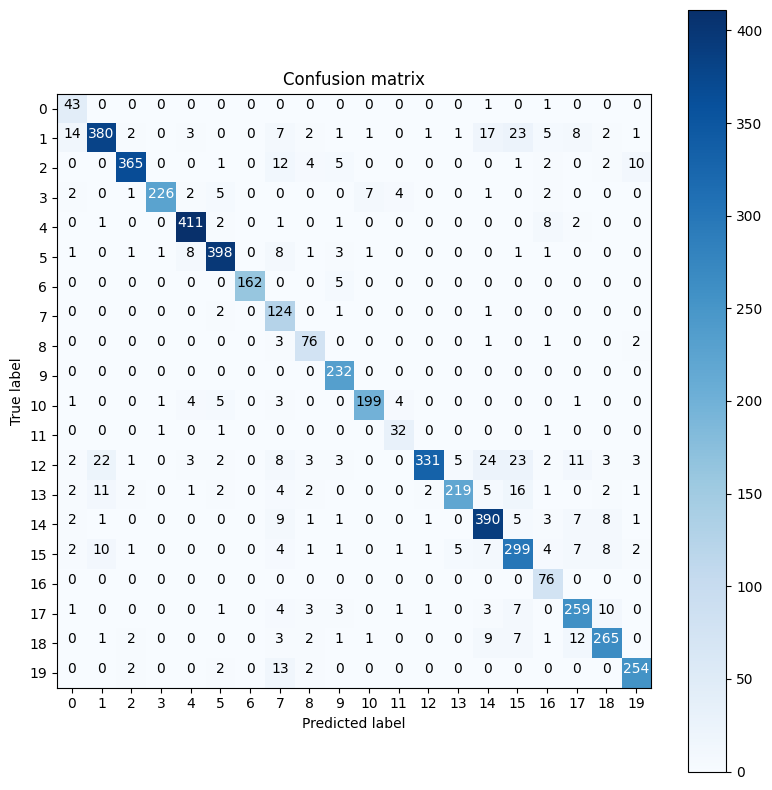

In [ ]:
# Evaluate the model
all_preds, all_labels = evaluate_model(model, dataloaders['validation'])

# Plotting the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plot_confusion_matrix(conf_matrix, classes=[str(i) for i in range(20)])
plt.show()


## Training stochastic gradient descent model

In [ ]:
#classes = config.getint['dataset']['num_classes']
#stochastic gradient descent
%%time
modelSGD = ResNet50(img_channel=3, num_classes=20).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(modelSGD.parameters(), lr=0.01, momentum=0.9)
num_epochs = 20
batch_size = 64
out_path2 = get_unique_filename(prefix='mymodel2', suffix='.pt', folder='/content')

history2 = capture_output(Train, modelSGD, criterion, optimizer, num_epochs, batch_size, dataloaders, out_path2)
print(history2)

['Training Epoch 1/20 Loss: 2.8064 Accuracy: 0.1414 Balanced Accuracy: 0.1404', '', 'Validation Epoch 1/20 Loss: 2.7707 Accuracy: 0.1460 Balanced Accuracy: 0.2074', '', 'Training Epoch 2/20 Loss: 2.1563 Accuracy: 0.3129 Balanced Accuracy: 0.3169', '', 'Validation Epoch 2/20 Loss: 1.7371 Accuracy: 0.4109 Balanced Accuracy: 0.4994', '', 'Training Epoch 3/20 Loss: 1.1899 Accuracy: 0.6022 Balanced Accuracy: 0.6017', '', 'Validation Epoch 3/20 Loss: 1.0629 Accuracy: 0.6336 Balanced Accuracy: 0.7010', '', 'Training Epoch 4/20 Loss: 0.7955 Accuracy: 0.7453 Balanced Accuracy: 0.7451', '', 'Validation Epoch 4/20 Loss: 0.8051 Accuracy: 0.7392 Balanced Accuracy: 0.7832', '', 'Training Epoch 5/20 Loss: 0.5577 Accuracy: 0.8223 Balanced Accuracy: 0.8223', '', 'Validation Epoch 5/20 Loss: 0.6550 Accuracy: 0.7916 Balanced Accuracy: 0.8297', '', 'Training Epoch 6/20 Loss: 0.4450 Accuracy: 0.8591 Balanced Accuracy: 0.8588', '', 'Validation Epoch 6/20 Loss: 0.6020 Accuracy: 0.8311 Balanced Accuracy: 0.85

In [ ]:
# Extracting loss values from the captured output
train_losses = []
valid_losses = []

for line in history2:
    if line.startswith('Training Epoch'):
        train_loss = float(line.split('Loss: ')[1].split()[0])
        train_losses.append(train_loss)
    elif line.startswith('Validation Epoch'):
        valid_loss = float(line.split('Loss: ')[1].split()[0])
        valid_losses.append(valid_loss)

## Plotting graphs regarding the results of training of stochastic gradient descent model

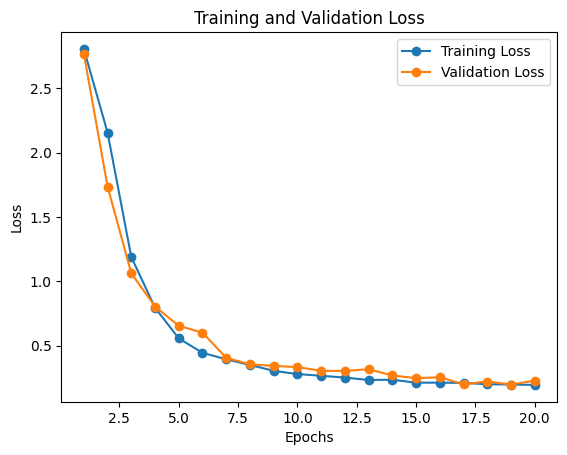

In [ ]:
# plotting loss graphs
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


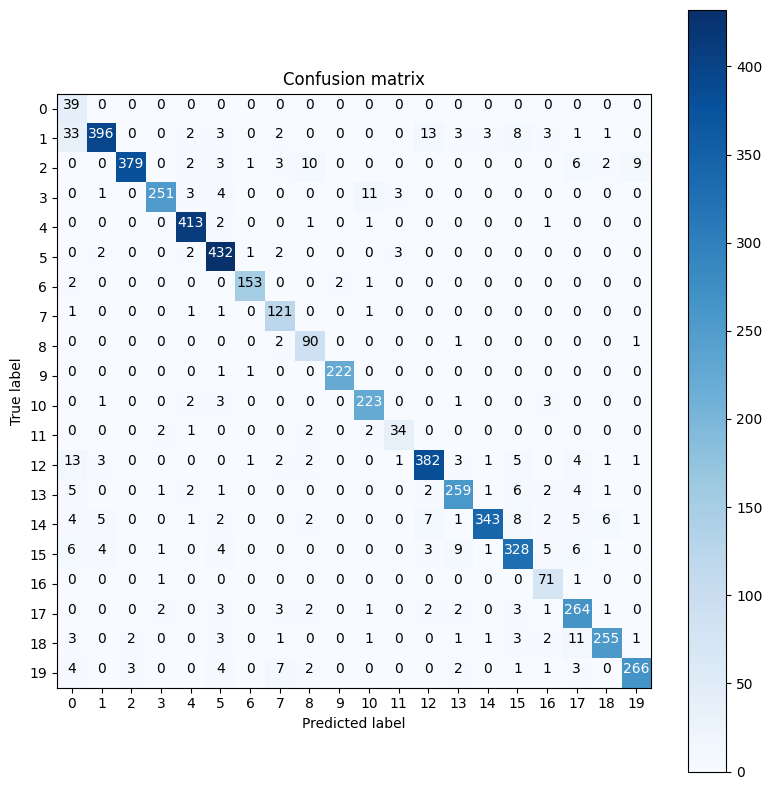

In [ ]:
# Evaluate the model
all_preds, all_labels = evaluate_model(modelSGD, dataloaders['validation'])

# Plotting the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plot_confusion_matrix(conf_matrix, classes=[str(i) for i in range(20)])
plt.show()
